In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize.treebank import TreebankWordTokenizer
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate,  Dropout
#from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score,classification_report
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import os
import sys

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re, string, unicodedata
from collections import defaultdict

import nltk
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer ,PorterStemmer,WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer
from textblob import Word

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
train_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

In [4]:
def Pre_processing(df):
    """
    This function performs custom normalization on text column
    """
    #Defining the stop words from nltk
    stopwords_all = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    df=df.apply(lambda x: re.sub(r'\([^()]*\)', '', x)) #Remove paranthesis
    df=df.apply(lambda x: x.lower())  #Lowercase the reviews
    df=df.apply(lambda x: re.sub('\w*\d\w*','', x)) #Remove digits and words containing digits
    df=df.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x)) #Remove Punctuations
    df=df.apply(lambda x: re.sub(' +',' ',x))  # remove extra spaces
    df=df.apply(lambda x: re.sub("</?.*?>"," <> ",x))  #remove tags
    df=df.apply(lambda x: " ".join(lemmatizer.lemmatize(word) for word in x.split())) # lemmatization
    #df=df.apply(lambda x: " ".join([word for word in x.split() if len(word)>1])) # remove single characters like a 
    df=df.apply(lambda x: " ".join([word for word in x.split() if word not in stopwords_all]))
    df=df.apply(lambda x: re.sub(r'([a-z])([A-Z])',r'\1 \2',x))
    
    symbols_to_isolate = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'
    symbols_to_delete = '\n🍕\r🐵😑\xa0\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'

    isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
    remove_dict = {ord(c):f'' for c in symbols_to_delete}
    
    df = df.apply(lambda x: x.translate(remove_dict)) 
    df = df.apply(lambda x: x.translate(isolate_dict))
    
    return df

train_df['comment_text'] = Pre_processing(train_df['comment_text'])

In [5]:
target_col = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

train_df= train_df.append(train_df[train_df.threat==1], ignore_index=True)
train_df= train_df.append(train_df[train_df.threat==1], ignore_index=True)
train_df= train_df.append(train_df[train_df.identity_hate==1], ignore_index=True)
train_df= train_df.append(train_df[train_df.severe_toxic==1], ignore_index=True)

x_tr, X_test, y_tr, y_test = train_test_split(train_df['comment_text'], train_df[target_col], test_size=0.15, random_state=32,stratify=train_df[target_col])
x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size=0.193367882, random_state=42,stratify=y_tr)

In [6]:
cv = CountVectorizer(min_df=2)
x_train_word_vector=cv.fit_transform(x_train)

#get the words in a list
words = cv.get_feature_names()
#cv.stop_words_

x_val_word_vector=cv.transform(x_val)
x_test_word_vector=cv.transform(X_test)

In [7]:
tfidf = TfidfVectorizer(min_df=2,dtype=np.float32)
x_train_tfidf_vector = tfidf.fit_transform(x_train)
#tr_vect1.shape

x_val_tfidf_vector=tfidf.transform(x_val)
x_test_tfidf_vector=tfidf.transform(X_test)

Building 1 model for column:toxic

Confusion matrix
 [[23518   228]
 [ 1094  2288]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     23746
           1       0.91      0.68      0.78      3382

    accuracy                           0.95     27128
   macro avg       0.93      0.83      0.87     27128
weighted avg       0.95      0.95      0.95     27128

Accuracy: 0.951268
Precision: 0.909380
Recall: 0.676523
F1 score: 0.775856


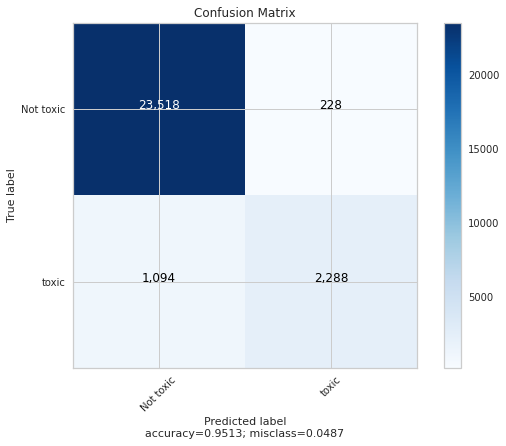

Building 2 model for column:severe_toxic

Confusion matrix
 [[26266    92]
 [  508   262]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     26358
           1       0.74      0.34      0.47       770

    accuracy                           0.98     27128
   macro avg       0.86      0.67      0.73     27128
weighted avg       0.97      0.98      0.97     27128

Accuracy: 0.977883
Precision: 0.740113
Recall: 0.340260
F1 score: 0.466192


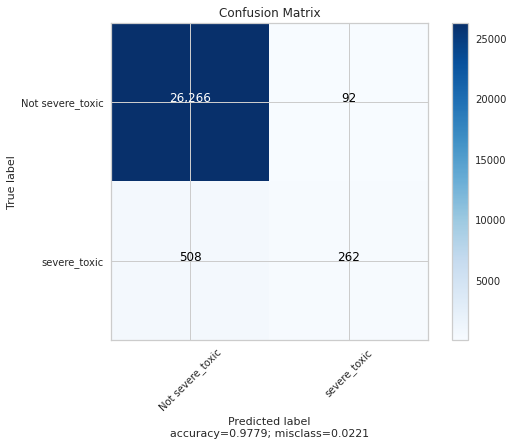

Building 3 model for column:obscene

Confusion matrix
 [[24942    74]
 [  929  1183]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     25016
           1       0.94      0.56      0.70      2112

    accuracy                           0.96     27128
   macro avg       0.95      0.78      0.84     27128
weighted avg       0.96      0.96      0.96     27128

Accuracy: 0.963027
Precision: 0.941130
Recall: 0.560133
F1 score: 0.702286


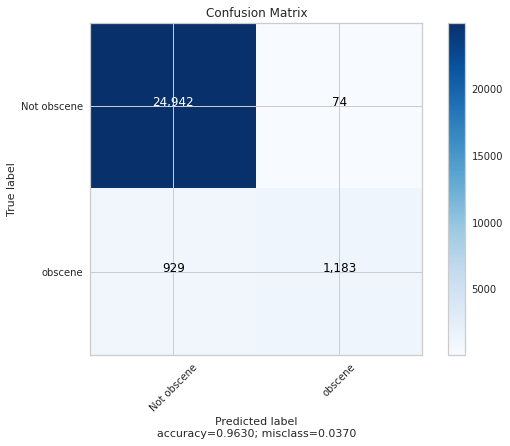

Building 4 model for column:threat

Confusion matrix
 [[26617    40]
 [  317   154]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26657
           1       0.79      0.33      0.46       471

    accuracy                           0.99     27128
   macro avg       0.89      0.66      0.73     27128
weighted avg       0.98      0.99      0.98     27128

Accuracy: 0.986840
Precision: 0.793814
Recall: 0.326964
F1 score: 0.463158


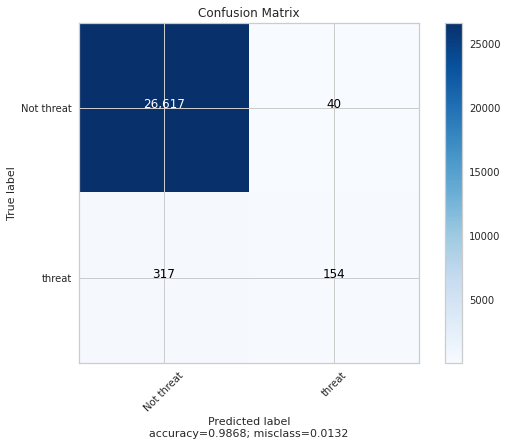

Building 5 model for column:insult

Confusion matrix
 [[24971   137]
 [ 1211   809]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     25108
           1       0.86      0.40      0.55      2020

    accuracy                           0.95     27128
   macro avg       0.90      0.70      0.76     27128
weighted avg       0.95      0.95      0.94     27128

Accuracy: 0.950310
Precision: 0.855180
Recall: 0.400495
F1 score: 0.545516


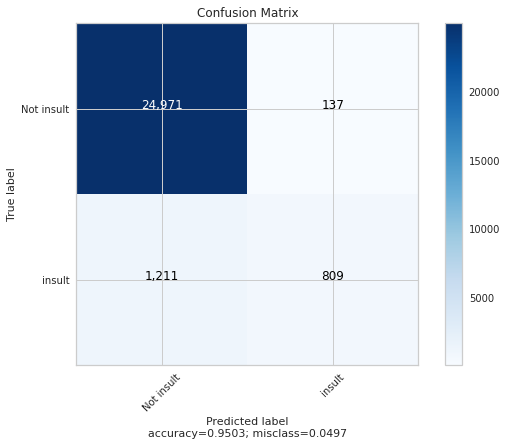

Building 6 model for column:identity_hate

Confusion matrix
 [[26384    50]
 [  597    97]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     26434
           1       0.66      0.14      0.23       694

    accuracy                           0.98     27128
   macro avg       0.82      0.57      0.61     27128
weighted avg       0.97      0.98      0.97     27128

Accuracy: 0.976150
Precision: 0.659864
Recall: 0.139769
F1 score: 0.230678


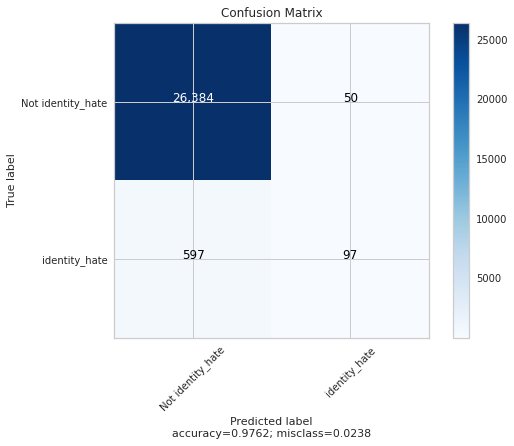

In [9]:
prd = np.zeros((x_val_word_vector.shape[0],y_train.shape[1]))

cv_score =[]
for i,col in enumerate(target_col):
    
    print('Building {} model for column:{''}'.format(i+1,col)) 
    
#     sm = SMOTE(random_state = 127)
#     x_train_word_vector_sm, y_train_sm = sm.fit_resample(x_train_word_vector, y_train[col])
    
    
    lr = LogisticRegression(solver='liblinear')
    lr.fit(x_train_word_vector,y_train[col])
        
    #cv_score.append(lr.score)
    prd[:,i] = lr.predict(x_val_word_vector)  # predict_proba
    print('\nConfusion matrix\n',confusion_matrix(y_val[col],prd[:,i]))
    print(classification_report(y_val[col],prd[:,i]))
    
    accuracy = accuracy_score(y_val[col],prd[:,i])
    print('Accuracy: %f' % accuracy)

    precision = precision_score(y_val[col],prd[:,i])
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_val[col],prd[:,i])
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_val[col],prd[:,i])
    print('F1 score: %f' % f1)
    
#     try:
#         print('ROC-AUC Score: ',roc_auc_score(y_val[col],prd[:,i]))
        
#     except:
#         continue
    
    plot_confusion_matrix(cm       = confusion_matrix(y_val[col],prd[:,i]), 
                      normalize    = False,
                      target_names = ['Not {}'.format(col) , '{}'.format(col)],
                      title        = "Confusion Matrix")

In [21]:
print(result)

[[0.95499115 0.93586123 0.68598462 0.79167378]
 [0.98186376 0.77362205 0.51038961 0.61502347]
 [0.97415954 0.93956386 0.71401515 0.81140705]
 [0.99229578 0.91719745 0.61146497 0.73375796]
 [0.9674506  0.8787475  0.6529703  0.74921897]
 [0.98521822 0.84149184 0.52017291 0.64292075]]


Building 1 model for column:toxic

Confusion matrix
 [[23587   159]
 [ 1062  2320]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     23746
           1       0.94      0.69      0.79      3382

    accuracy                           0.95     27128
   macro avg       0.95      0.84      0.88     27128
weighted avg       0.95      0.95      0.95     27128

Accuracy: 0.954991
Precision: 0.935861
Recall: 0.685985
F1 score: 0.791674


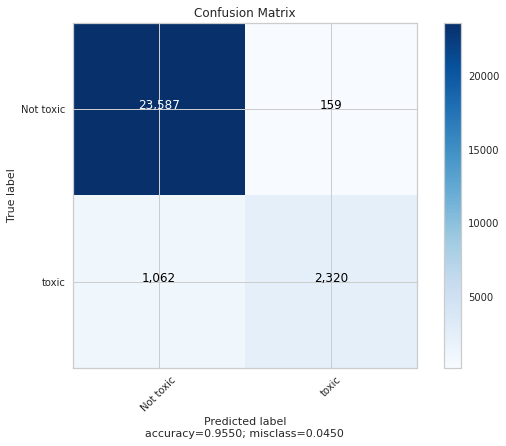

Building 2 model for column:severe_toxic

Confusion matrix
 [[26243   115]
 [  377   393]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26358
           1       0.77      0.51      0.62       770

    accuracy                           0.98     27128
   macro avg       0.88      0.75      0.80     27128
weighted avg       0.98      0.98      0.98     27128

Accuracy: 0.981864
Precision: 0.773622
Recall: 0.510390
F1 score: 0.615023


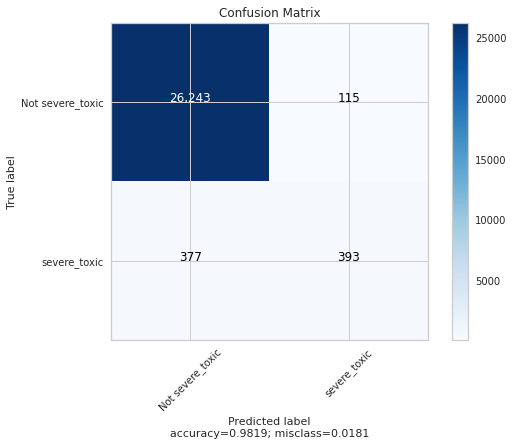

Building 3 model for column:obscene

Confusion matrix
 [[24919    97]
 [  604  1508]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     25016
           1       0.94      0.71      0.81      2112

    accuracy                           0.97     27128
   macro avg       0.96      0.86      0.90     27128
weighted avg       0.97      0.97      0.97     27128

Accuracy: 0.974160
Precision: 0.939564
Recall: 0.714015
F1 score: 0.811407


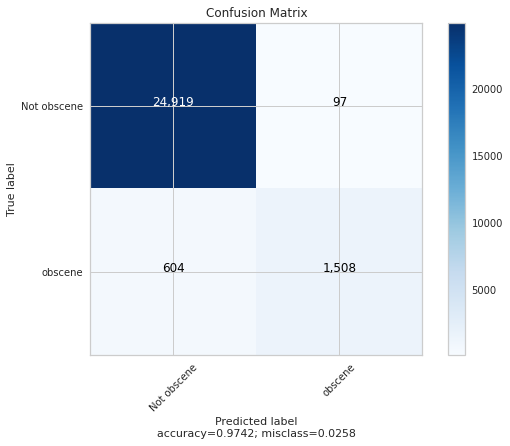

Building 4 model for column:threat

Confusion matrix
 [[26631    26]
 [  183   288]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     26657
           1       0.92      0.61      0.73       471

    accuracy                           0.99     27128
   macro avg       0.96      0.81      0.86     27128
weighted avg       0.99      0.99      0.99     27128

Accuracy: 0.992296
Precision: 0.917197
Recall: 0.611465
F1 score: 0.733758


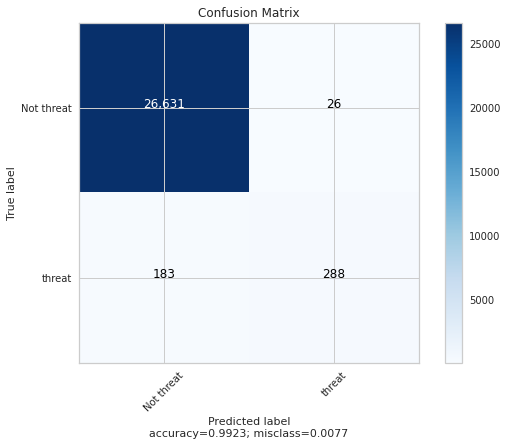

Building 5 model for column:insult

Confusion matrix
 [[24926   182]
 [  701  1319]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     25108
           1       0.88      0.65      0.75      2020

    accuracy                           0.97     27128
   macro avg       0.93      0.82      0.87     27128
weighted avg       0.97      0.97      0.97     27128

Accuracy: 0.967451
Precision: 0.878748
Recall: 0.652970
F1 score: 0.749219


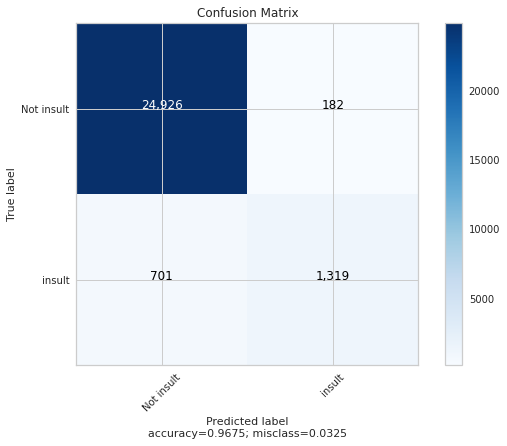

Building 6 model for column:identity_hate

Confusion matrix
 [[26366    68]
 [  333   361]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26434
           1       0.84      0.52      0.64       694

    accuracy                           0.99     27128
   macro avg       0.91      0.76      0.82     27128
weighted avg       0.98      0.99      0.98     27128

Accuracy: 0.985218
Precision: 0.841492
Recall: 0.520173
F1 score: 0.642921


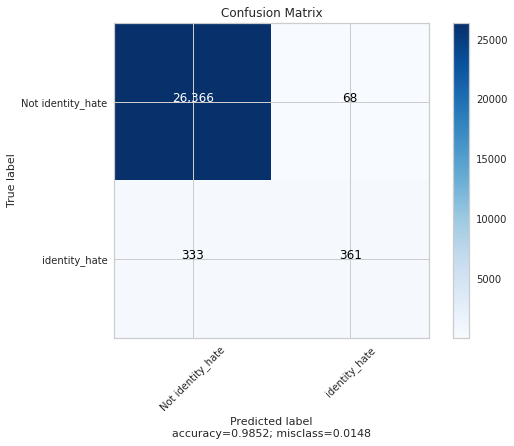

In [20]:
prd = np.zeros((x_val_tfidf_vector.shape[0],y_train.shape[1]))
result=np.ndarray(shape=(6,4))
cv_score =[]
for i,col in enumerate(target_col):
    
    print('Building {} model for column:{''}'.format(i+1,col)) 
    
#     sm = SMOTE(random_state = 127)
#     x_train_word_vector_sm, y_train_sm = sm.fit_resample(x_train_word_vector, y_train[col])
    
    
    lr = LogisticRegression(solver='liblinear')
    lr.fit(x_train_tfidf_vector,y_train[col])
        
    #cv_score.append(lr.score)
    prd[:,i] = lr.predict(x_val_tfidf_vector)  # predict_proba
    print('\nConfusion matrix\n',confusion_matrix(y_val[col],prd[:,i]))
    print(classification_report(y_val[col],prd[:,i]))
    
    accuracy = accuracy_score(y_val[col],prd[:,i])
    print('Accuracy: %f' % accuracy)

    precision = precision_score(y_val[col],prd[:,i])
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_val[col],prd[:,i])
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_val[col],prd[:,i])
    print('F1 score: %f' % f1)
    
    result[i][0]=accuracy
    result[i][1]=precision
    result[i][2]=recall
    result[i][3]=f1
    
#     try:
#         print('ROC-AUC Score: ',roc_auc_score(y_val[col],prd[:,i]))
        
#     except:
#         continue
    
    plot_confusion_matrix(cm       = confusion_matrix(y_val[col],prd[:,i]), 
                      normalize    = False,
                      target_names = ['Not {}'.format(col) , '{}'.format(col)],
                      title        = "Confusion Matrix")
    
